### Massaging the Data
Write Python code to convert the Titanic training data into a form suitable for neural network analysis. Pick 7 properties to use, so your input will have shape (*, 7). Several points to consider:

Decide how to handle missing age data. This may involve adding another property, which can be one of your 7.
Deal with the parsing hassles, especially those surrounding passenger names. Your program should read the original csv from Kaggle, not a hand-tweaked file. This parsing is a basic Python coding problem, but it is exemplary of the "rusty plumbing" work that often comes with processing a data set for machine learning.
Rework the data into normal distributions with mean 0 and std 1.

#### Imports

In [1]:
import numpy as np
import csv
from keras.datasets import boston_housing
from keras import models, layers
from matplotlib import pyplot as plt
np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


#### Massage
Create a PeopleSet class that stores the values for a Titanic data set of people, either the training set or the test set. PeopleSet's properties include an array of ids, an array of labels (if available) and a tensor of input properties. Each of these have the same length (or 0-dimension length for the tensor) with one entry for each sample. The latter two are ndarrays suitable for use in training a Keras model. PeopleSet has a method that takes a list of CSV file lines of the format provided by Kaggle, and populates its properties by parsing those lines. You may use Python's CSV library, but the parameter passed should still be an iterable list of strings; don't assume in PeopleSet that the data is coming from a file.

In [2]:
class PeopleSet:
    def __init__(self):
        self.ids = None
        self.labels = None
        self.input_properties = None

    def __eq__(self, other):
        return ((type(other) == PeopleSet)
          and self.ids == other.ids
          and self.labels == other.labels
          and self.input_properties == other.input_properties
        )

    def __repr__(self):
        return ("PeopleSet({!r}, {!r}, {!r})".format(self.ids, self.labels, self.input_properties))
    
    def fixInput(self,input_properties):
        sex={'female':'0','male':'1'}
        embark={'C':'0','S':'1','Q':'2','':'3'}
        input_properties[:,1]=np.vectorize(sex.__getitem__)(input_properties[:,1])
        input_properties[:,6]=np.vectorize(embark.__getitem__)(input_properties[:,6])
        np.putmask(input_properties,input_properties=='',0)
        return input_properties.astype(float)
    
    def normalize(self,toNormalize):
        return (toNormalize-np.mean(toNormalize,axis=0))/np.std(toNormalize,axis=0)
    
    def populate(self,iterCSV):
        inter_csv_list=np.asarray(list(iterCSV))
        self.ids=inter_csv_list[1:,np.where(inter_csv_list=='PassengerId')[1]].astype(int)
        self.labels=inter_csv_list[1:,np.where(inter_csv_list=='Survived')[1]].astype(int)
        pClassIndex=np.where(inter_csv_list=='Pclass')[1]
        inputProperties=[pClassIndex,pClassIndex+2,pClassIndex+3,pClassIndex+4,pClassIndex+5,pClassIndex+7,pClassIndex+9]
        self.input_properties=np.hstack(inter_csv_list[1:,inputProperties]).T
        self.input_properties=self.fixInput(self.input_properties)
        self.input_properties=self.normalize(self.input_properties)


#### Populate train data

In [3]:
with open('train.csv') as csvfile:
    iterCSV=csv.reader(csvfile)
    train=PeopleSet()
    train.populate(iterCSV)

#### Testing Parameters
You'll set up a neural network to analyze the Titanic data, with a single output node using a sigmoid activation. Explore the effectiveness of a variety of configurations -- number of layers, internal activation functions, dimension of layers, etc. Design a K-fold validation test system for this, using the Houses.py class example as a basis. Your system should allow you to quickly try out a variety of architectures, and determine both their loss and the number of epochs needed to fit them without overfitting. Find the simplest NN configuration that gets you an RSE loss of .14 or less on average across the folds.

Write a brief text file describing which configurations you tried, and which one you settled on. Just a few lines is sufficient.

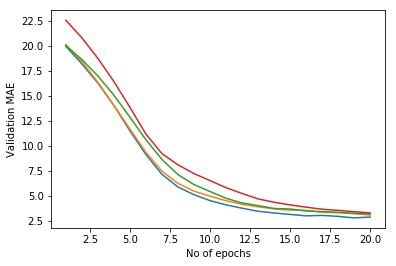

In [4]:
def build_and_train_model(train_data, train_targets, val_data, val_targets, num_epochs, batch_size):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Linear activation to get unskewed num range
  
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history = model.fit(train_data, train_targets, 
     validation_data = (val_data, val_targets),
     epochs=num_epochs, batch_size=batch_size, verbose = 0)
     
    return (model, history.history['val_mean_absolute_error'])

def fold_test(train_data, train_targets, num_folds, num_epochs):
    num_samples = train_data.shape[0]
    val_size = num_samples // num_folds
    batch_size = (num_samples - val_size) // 500 # Up to 500 batches, ....
    batch_size = max(32, batch_size)             # but at least 32 samples, ...
    batch_size = min(num_samples, batch_size)    # and no more than num_samples
    mae_per_fold = []
    
    # Repeat test for each fold
    for fold in range(num_folds):
        val_data = train_data[fold*val_size : (fold+1)*val_size]
        val_targets = train_targets[fold*val_size : (fold+1)*val_size]
        
        partial_train_data = np.concatenate(
           [train_data[ :fold*val_size], train_data[(fold+1)*val_size: ]],
           axis=0      # Concatenate along sample axis
        )
        
        partial_train_targets = np.concatenate(
           [train_targets[ :fold*val_size], train_targets[(fold+1)*val_size: ]],
           axis=0      # Concatenate along sample axis
        )

        model, history = build_and_train_model(partial_train_data, partial_train_targets,
         val_data, val_targets, num_epochs, batch_size)
        
        # model.evaluate(val_data, val_targets, verbose=0)
        # print(model.metrics_names, mse, mae)
        
        mae_per_fold.append(history)
        
    return mae_per_fold
        
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
 
#print(train_data[0])
#print(train_targets[0])
#exit()

mean = train_data.mean(axis=0)      # Average corresponding values across sample axis
train_data -= mean                  # Shift so average is zero

std = train_data.std(axis=0)     
train_data /= std                   # Scale so std = 1

test_data = (test_data - mean)/std  # Test data uses train data parameters

# print(train_data[0])
# print(train_targets[0])
# exit()

mae_per_fold = fold_test(train_data, train_targets, 4, 20)

# print(mae_per_fold)

for history in mae_per_fold:
    plt.plot(range(1, len(history)+1), history)

plt.xlabel('No of epochs')
plt.ylabel('Validation MAE')
plt.show()